# No Limit Texas Hold'em Deep Q learning

This notebook is using modern deep learning libraries to try to solve No Limit Hold'em (NLH). There are AIs developed that have beaten world class players in heads-up (2 players) NLH. We still have a long way to go here.

To run the notebook you need to install the https://github.com/VinQbator/holdem fork of the holdem library. A lot of bugfixes and changes were needed to effectively run the environment for deep learning.

Also keras-rl should be installed from https://github.com/VinQbator/keras-rl. Sorry for the inconvenience.

Rest of the libraries are found from pip as listed in the following imports section.

A lot of heavy lifting is in .py files adjacent to the notebook to keep the notebook clean.

Most of the effort here is put into building a framework to enable more serious development in the future.

# Imports

In [1]:
from players.atm import ATM
from players.ai_player import AIPlayer
from players.random_player import RandomPlayer
from training_env import TrainingEnv
from agents import build_dqn_agent, fit_agent, train_loop, load_agent_weights
from models import simple_model, complex_model
from util import visualize_history, use_jupyter

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
use_jupyter()

# Feature Engineering

### Some of the stuff that is happening in the wrapper layer for the holdem gym environment.
* Positions are one-hot encoded
* Pot and bet sizes are normalized to 100 big blinds
* Hand ranking either normalized or one-hot encoded
* Cards are one-hot encoded

# Action space

### Essentially infinite or at least large action space is split up into

* Base moves like FOLD/CALL/CHECK

* And few common bet/raise sizes relative to the pot size: 1/5, 1/4, 1/3, 2/5, 1/2, 3/5, 2/3, 3/4, 4/5, 1, 4/3, 5/3, 2, 3, 5, 10, 15, 20, 30, 50, 75, 100

In [4]:
# How many players in table
NUMBER_OF_SEATS = 2
# Max betsize in simulation environment (shouldn't really matter with discrete relative to pot sizing)
MAX_BET = 100000
# 'norm' (normalized) or 'one-hot' < how to encode player hand ranking from 7642 unique values
RANK_ENCODING = 'norm'

WINDOW = 20
MODEL = complex_model

FIRST_RUN_STEPS = 500
SECOND_RUN_STEPS = 500
THIRD_RUN_STEPS = 1000
THIRD_RUN_ITERATIONS = 50

In [5]:
# Lets start with playing against player that always calls or checks based on which is currently valid move
# Hopefully this will teach the agent something about hand strength at least
env = TrainingEnv.build_environment(ATM(), NUMBER_OF_SEATS, debug=False)

##### First lets train a simple model with 1 step sequences against an opponent who always calls or folds based on whichever move is valid

No need to train against it for long - we just want to learn some basics

In [6]:
model = MODEL(WINDOW, env.n_observation_dimensions, env.n_actions)
print(model.summary())
# window_length - how many timesteps to look into past (will multiply observation space by this, be careful)
# enable_double_dqn - https://arxiv.org/pdf/1509.06461.pdf
# enable_dueling_network - ???
# train_interval - every how many steps to run a train cycle (or if in 0...1 range, the soft update weight)
# n_warmup_steps - how many steps to run without training
# batch_size - number of (s, a, G) triplets to train on in one training cycle (as a batch)
# gamma - future reward discount essentially
# memory_interval - how often to add last step to memory buffer (discarding every other)

agent = build_dqn_agent(model, env.n_actions, window_length=WINDOW, target_model_update=0.001, 
                        enable_double_dqn=True, enable_dueling_network=True, dueling_type='avg', 
                        train_interval=100, n_warmup_steps=50, batch_size=32, gamma=.99, memory_interval=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 7920)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              32444416  
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout_2 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout_3 (Dropout)          (None, 4096)              0         
__________

In [7]:
# Let's play for 100000 steps (decisions made by AI)
agent, hist = fit_agent(agent, env, FIRST_RUN_STEPS, debug=False) 

Training for 50000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 256s 26ms/step - reward: 0.1944
3466 episodes - episode_reward: 0.561 [-75.600, 74.000] - loss: 98.166 - mean_absolute_error: 0.690 - mean_q: 0.879 - money_won: -1.206

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 248s 25ms/step - reward: 0.4044
3439 episodes - episode_reward: 1.176 [-74.800, 68.400] - loss: 88.370 - mean_absolute_error: 0.676 - mean_q: 0.873 - money_won: 4.093

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 247s 25ms/step - reward: 0.1566
3448 episodes - episode_reward: 0.454 [-68.400, 70.000] - loss: 90.334 - mean_absolute_error: 0.682 - mean_q: 0.914 - money_won: -2.118

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 248s 25ms/step - reward: 0.2596
3439 episodes - episode_reward: 0.755 [-74.200, 77.200] - loss: 92.177 - mean_absolute_error: 0.677 - mean_q:

## As we can see the simple network was able to learn a bit and achieve a positive winrate

NB! The Winrate and Winnings plots show $ not big blinds. (Didn't want to run the notebook again, fixed in code)

Total $ won: -4510
Winrate BB/100: -1.055094163060007
Total hands: 17098


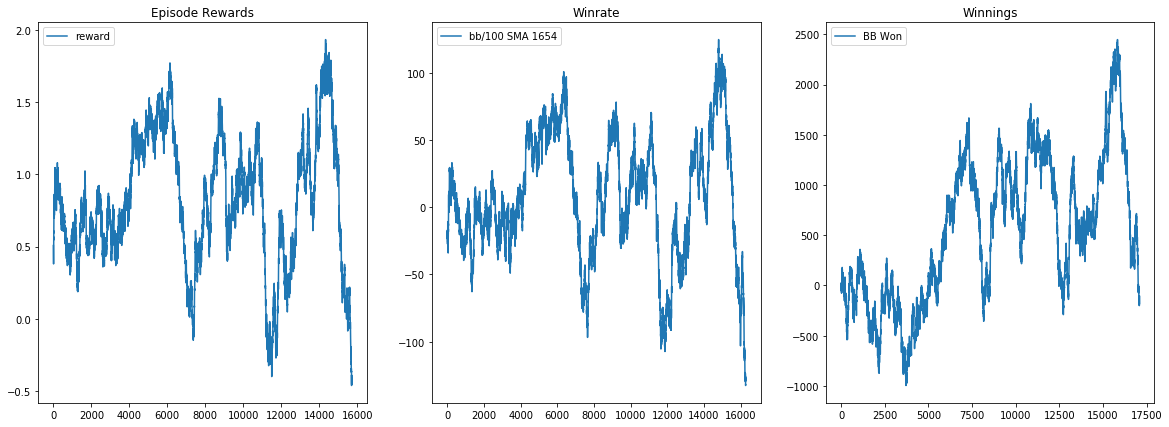

In [8]:
# Some plots of how the training session went
visualize_history(hist)

### Hand history rendering is still a bit wonky, but it's clear that the bot is not making too smart choices

In [9]:
# Let's evaluate our agent for 5 episodes (hands).
agent.test(env, nb_episodes=5, visualize=True)

Testing for 5 episodes ...
total pot: 140
last action by player 1:
- call, current bet: 0
community:
- [A♦],[4♦],[K♠],[  ],[  ] 
players:
0 BB [3♦],[8♣] stack: 1930
1 SB [5♣],[A♥] stack: 1930
total pot: 2940
last action by player 1:
- call, current bet: 0
community:
- [A♦],[4♦],[K♠],[Q♦],[  ] 
players:
0 BB [3♦],[8♣] stack: 530
1 SB [5♣],[A♥] stack: 530
total pot: 4000
last action by player 1:
- call, current bet: 0
community:
- [A♦],[4♦],[K♠],[Q♦],[  ] 
players:
0 BB [3♦],[8♣] stack: 1560
1 SB [5♣],[A♥] stack: 2440
Episode 1: reward: -17.200, steps: 3
total pot: 25
last action by player 1:
_ check
community:
- [8♦],[8♥],[2♣],[  ],[  ] 
players:
0 SB [3♠],[9♠] stack: 1975
1 BB [Q♦],[4♦] stack: 1975
total pot: 525
last action by player 1:
_ check
community:
- [8♦],[8♥],[2♣],[2♦],[  ] 
players:
0 SB [3♠],[9♠] stack: 1725
1 BB [Q♦],[4♦] stack: 1725
total pot: 2625
last action by player 1:
_ check
community:
- [8♦],[8♥],[2♣],[2♦],[J♥] 
players:
0 SB [3♠],[9♠] stack: 675
1 BB [Q♦],[4♦] stac

# Lets now play against opponent who makes totally random moves

In [12]:
# Lets play against our bot with totally random moves now
# Hopefully it teaches the agent at least something about how to act on wide range of situations
env = TrainingEnv.build_environment(RandomPlayer(), NUMBER_OF_SEATS, debug=False)

In [13]:
# Train for playing against RandomPlayer
agent, hist = fit_agent(agent, env, SECOND_RUN_STEPS, False, hist)

Training for 50000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 257s 26ms/step - reward: 0.2750
4679 episodes - episode_reward: 0.588 [-75.800, 78.400] - loss: 136.509 - mean_absolute_error: 0.732 - mean_q: 0.876 - money_won: -1.311

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 253s 25ms/step - reward: 0.4384
4731 episodes - episode_reward: 0.927 [-77.280, 79.000] - loss: 144.662 - mean_absolute_error: 0.737 - mean_q: 0.872 - money_won: 2.681

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 251s 25ms/step - reward: 0.3804
4709 episodes - episode_reward: 0.808 [-77.200, 75.400] - loss: 145.694 - mean_absolute_error: 0.750 - mean_q: 0.897 - money_won: 1.269

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 251s 25ms/step - reward: 0.6185
4709 episodes - episode_reward: 1.313 [-78.240, 76.400] - loss: 137.931 - mean_absolute_error: 0.734 - mean

# Our winrate has increased even if the opponent is not totally predictable

Total $ won: 92918
Winrate BB/100: 9.18388930071658
Total hands: 40470


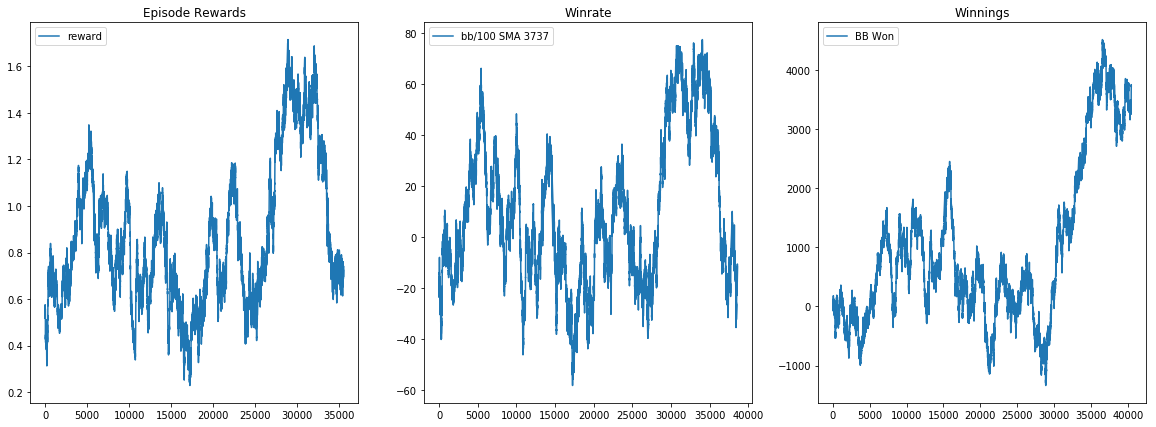

In [14]:
visualize_history(hist)

# Hand history shows that AI is still making quite random moves

In [15]:
agent.test(env, nb_episodes=5, visualize=True)

Testing for 5 episodes ...
total pot: 1015
last action by player 1:
^ raise, current bet: 665
community:
- [  ],[  ],[  ],[  ],[  ] 
players:
0 BB [T♣],[T♠] stack: 1650
1 SB [K♣],[9♣] stack: 1335
total pot: 4000
last action by player 1:
- call, current bet: 0
community:
- [  ],[  ],[  ],[  ],[  ] 
players:
0 BB [T♣],[T♠] stack: 2860
1 SB [K♣],[9♣] stack: 1140
Episode 1: reward: 34.800, steps: 2
total pot: 0
last action by player 1:
x fold
community:
- [  ],[  ],[  ],[  ],[  ] 
players:
0 SB [2♦],[3♦] stack: 1975
1 BB [8♥],[2♠] stack: 1990
Episode 2: reward: 0.000, steps: 1
total pot: 2070
last action by player 1:
^ raise, current bet: 2000
community:
- [  ],[  ],[  ],[  ],[  ] 
players:
0 BB [6♦],[5♠] stack: 1930
1 SB [7♥],[8♣] stack: 0
total pot: 4000
last action by player 0:
- call, current bet: 0
community:
- [  ],[  ],[  ],[  ],[  ] 
players:
0 BB [6♦],[5♠] stack: 1500
1 SB [7♥],[8♣] stack: 2500
Episode 3: reward: -19.600, steps: 2
total pot: 4000
last action by player 0:
- call, c

In [ ]:
agent, hist = train_loop(agent, complex_model, env, steps_in_iteration=THIRD_RUN_STEPS, 
                         n_iterations=THIRD_RUN_ITERATIONS, window_length=WINDOW, debug=False)

ITERATION 0
Total $ won: -1910535
Winrate BB/100: -166.9026819253953
Total hands: 45788
ITERATION 1
Total $ won: -4489857
Winrate BB/100: -182.48854837726338
Total hands: 98414
ITERATION 2


In [ ]:
agent.test(env, nb_episodes=50, visualize=True)

In [ ]:
# Let's benchmark against ATM
env = build_environment(ATM(), False)
hist = agent.test(env, nb_episodes=100000, visualize=False, verbose=0, history=hist)
visualize_history(hist)

In [ ]:
# Let's benchmark against RandomPlayer
env = build_environment(RandomPlayer(), False)
hist = agent.test(env, nb_episodes=100000, visualize=False, verbose=0, history=hist)
visualize_history(hist)